In [10]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import time
import textwrap
import pickle
import scipy.stats as stats

from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from scipy import spatial
from scipy import spatial

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn import utils
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, precision_score, roc_curve,auc, recall_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import multiprocessing
cores = multiprocessing.cpu_count()

fontname = 'Montserrat-Regular.ttf'

## Determine the best model for movie genre classification

Read in data.

In [11]:
X_train = pickle.load(open("X_train.pickle", "rb"))
y_train = pickle.load(open("y_train.pickle", "rb"))
X_test = pickle.load(open("X_test.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))

Model grid search with CB, no SMOTE.

In [12]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
cv_results = []

X_train = np.array(X_train)
y_train = np.array(y_train)

models = {'Random Forest': RandomForestClassifier(),
         'SGD': SGDClassifier(),
         'Naive Bayes': GaussianNB()}

for model_name, model in models.items():
    for train_ind,val_ind in kf.split(X_train,y_train):
        X_tr, y_tr = X_train[train_ind], y_train[train_ind]
        X_val, y_val = X_train[val_ind], y_train[val_ind]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        cv_results.append([model_name,f1])

cv_df = pd.DataFrame(cv_results)
cv_df.columns = ['model','f1']

model_grid_mean_f1 = cv_df.groupby(['model']).mean()
model_grid_mean_f1.columns=['mean_f1_score, no SMOTE']
model_grid_f1_var = cv_df.groupby(['model']).var()
model_grid_f1_var.columns=['f1_variance, no SMOTE']

In [14]:
cv_results = model_grid_mean_f1
cv_results

,"mean_f1_score, no SMOTE"
model,
Naive Bayes,0.930810
Random Forest,0.853293
SGD,0.960110


In [30]:
model_grid_f1_var

,"f1_variance, no SMOTE"
model,
Naive Bayes,0.000139
Random Forest,0.000341
SGD,0.000077


Model grid search with CB, with SMOTE.

In [31]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
cv_results = []
smoter = SMOTE(random_state=13)

X_train = np.array(X_train)
y_train = np.array(y_train)

models = {'Random Forest': RandomForestClassifier(),
         'SGD': SGDClassifier(),
         'Naive Bayes': GaussianNB()}

for model_name, model in models.items():
    for train_ind,val_ind in kf.split(X_train,y_train):
        X_tr, y_tr = X_train[train_ind], y_train[train_ind]
        X_smote_train, y_smote_train = smoter.fit_sample(X_tr,y_tr)
        X_val, y_val = X_train[val_ind], y_train[val_ind]
        model.fit(X_smote_train, y_smote_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        cv_results.append([model_name,f1])

cv_df = pd.DataFrame(cv_results)
cv_df.columns = ['model','f1']

model_grid_mean_f1 = cv_df.groupby(['model']).mean()
model_grid_mean_f1.columns=['mean_f1_score, SMOTE']
model_grid_f1_var = cv_df.groupby(['model']).var()
model_grid_f1_var.columns=['f1_variance, SMOTE']

In [32]:
model_grid_mean_f1

,"mean_f1_score, SMOTE"
model,
Naive Bayes,0.894369
Random Forest,0.880217
SGD,0.965535


In [33]:
model_grid_f1_var

,"f1_variance, SMOTE"
model,
Naive Bayes,0.000659
Random Forest,0.000435
SGD,0.000024


Smoting training data to deal with class imbalance.

In [36]:
X_smoted, y_smoted = smoter.fit_sample(X_train,y_train)

Fit and predict.

In [128]:
"""
Random Forest
"""
rf = RandomForestClassifier(random_state=13)
rf_smoted = RandomForestClassifier(random_state=13)

rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

rf_smoted.fit(X_smoted,y_smoted)
rf_y_pred_smoted = rf_smoted.predict(X_test)

"""
SGD
"""
sgd = SGDClassifier(random_state=13)
sgd_smoted = SGDClassifier(random_state=13)

sgd.fit(X_train, y_train)
sgd_y_pred = sgd.predict(X_test)

sgd_smoted.fit(X_smoted,y_smoted)
sgd_y_pred_smoted = sgd_smoted.predict(X_test)

"""
Gaussian Naive Bayes
"""
gnb = GaussianNB()
gnb_smoted = GaussianNB()

gnb.fit(X_train, y_train)
gnb_y_pred = gnb.predict(X_test)

gnb_smoted.fit(X_smoted,y_smoted)
gnb_y_pred_smoted = gnb_smoted.predict(X_test)

In [127]:
print("Random Forest(no SMOTE), F1 Score: ", f1_score(y_test,rf_y_pred,average='weighted'))
print("Random Forest(SMOTE), F1 Score: ", f1_score(y_test,rf_y_pred_smoted,average='weighted'))
print("")
print("SGD(no SMOTE), F1 Score: ", f1_score(y_test,sgd_y_pred,average='weighted'))
print("SGD(SMOTE), F1 Score: ", f1_score(y_test,sgd_y_pred_smoted,average='weighted'))
print("")
print("Gausian NB(no SMOTE), F1 Score: ", f1_score(y_test,gnb_y_pred,average='weighted'))
print("Gausian NB(SMOTE), F1 Score: ", f1_score(y_test,gnb_y_pred_smoted,average='weighted'))
print("")

Random Forest(no SMOTE), F1 Score:  0.6798029461314143
Random Forest(SMOTE), F1 Score:  0.6940045322010807

SGD(no SMOTE), F1 Score:  0.6699215117869523
SGD(SMOTE), F1 Score:  0.6730663979769768

Gausian NB(no SMOTE), F1 Score:  0.6804435550440865
Gausian NB(SMOTE), F1 Score:  0.6656040744335247



In [129]:
print("Random Forest(no SMOTE), Recall Score: ", recall_score(y_test,rf_y_pred,average='weighted'))
print("Random Forest(SMOTE), Recall Score: ", recall_score(y_test,rf_y_pred_smoted,average='weighted'))
print("")
print("SGD(no SMOTE), Recall Score: ", recall_score(y_test,sgd_y_pred,average='weighted'))
print("SGD(SMOTE), Recall Score: ", recall_score(y_test,sgd_y_pred_smoted,average='weighted'))
print("")
print("Gausian NB(no SMOTE), Recall Score: ", recall_score(y_test,gnb_y_pred,average='weighted'))
print("Gausian NB(SMOTE), Recall Score: ", recall_score(y_test,gnb_y_pred_smoted,average='weighted'))
print("")

Random Forest(no SMOTE), Recall Score:  0.6848484848484848
Random Forest(SMOTE), Recall Score:  0.6954545454545454

SGD(no SMOTE), Recall Score:  0.6696969696969697
SGD(SMOTE), Recall Score:  0.6727272727272727

Gausian NB(no SMOTE), Recall Score:  0.6787878787878788
Gausian NB(SMOTE), Recall Score:  0.6681818181818182



In [130]:
print("Random Forest(no SMOTE), Precision Score: ", precision_score(y_test,rf_y_pred,average='weighted'))
print("Random Forest(SMOTE), Precision Score: ", precision_score(y_test,rf_y_pred_smoted,average='weighted'))
print("")
print("SGD(no SMOTE), Precision Score: ", precision_score(y_test,sgd_y_pred,average='weighted'))
print("SGD(SMOTE), Precision Score: ", precision_score(y_test,sgd_y_pred_smoted,average='weighted'))
print("")
print("Gausian NB(no SMOTE), Precision Score: ", precision_score(y_test,gnb_y_pred,average='weighted'))
print("Gausian NB(SMOTE), Precision Score: ", precision_score(y_test,gnb_y_pred_smoted,average='weighted'))
print("")

Random Forest(no SMOTE), Precision Score:  0.6945032722859797
Random Forest(SMOTE), Precision Score:  0.6985228295239654

SGD(no SMOTE), Precision Score:  0.6769930028514113
SGD(SMOTE), Precision Score:  0.6775405515539409

Gausian NB(no SMOTE), Precision Score:  0.686143284328062
Gausian NB(SMOTE), Precision Score:  0.6847384675587715



Generate random grid for random search.

In [53]:
n_estimators = [int(x) for x in np.linspace(start = 600, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [600, 755, 911, 1066, 1222, 1377, 1533, 1688, 1844, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

Random search with model for grid search.

In [55]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_smoted, y_smoted);

with open('best_random_model.pickle', 'wb') as f:
    pickle.dump(rf_random.best_estimator_, f)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 30.5min finished


Evaluate random search results.

In [56]:
base_model = RandomForestClassifier(random_state=13)
base_model.fit(X_train,y_train)
y_pred_base = base_model.predict(X_test)

best_random = rf_random.best_estimator_
y_pred_random = best_random.predict(X_test)

print("Baseline F1 score: ", f1_score(y_test, y_pred_base, average='weighted'))
print("Random Search F1 score: ", f1_score(y_test, y_pred_random, average='weighted'))
print("")
print('Improvement of {:0.2f}%.'.format( 100 * (f1_score(y_test, y_pred_random, average='weighted')-f1_score(y_test, y_pred_base, average='weighted')) /f1_score(y_test, y_pred_base, average='weighted')))


Baseline F1 score:  0.6798029461314143
Random Search F1 score:  0.719892613107689

Improvement of 5.90%.


In [58]:
rf_random.best_params_

{'n_estimators': 755,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

Initiate grid search with best paramater values from random search.

In [62]:
params = {
    'max_depth': [90,100,110],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [700,750,800]
}

Perform grid search with new params.

In [64]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

imba_pipeline = make_pipeline(smoter,RandomForestClassifier(random_state=13))

new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params,scoring='f1_weighted',return_train_score=True, n_jobs = -1)
grid_imba.fit(X_train, y_train);

In [65]:
"""with open('model_grid_imba.pickle', 'wb') as f:
    pickle.dump(grid_imba.best_estimator_, f)"""

In [67]:
grid_imba.best_params_

{'randomforestclassifier__max_depth': 90,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__n_estimators': 800}

Evaluate final grid search model.

In [126]:
model_grid = grid_imba.best_estimator_
y_pred = model_grid.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Precision:  0.7261301455675612
Recall:  0.7181818181818181
F1:  0.7172515118874844


Confusion Matrix

In [134]:
data = pd.read_csv("cleaned_moviedataset.csv")

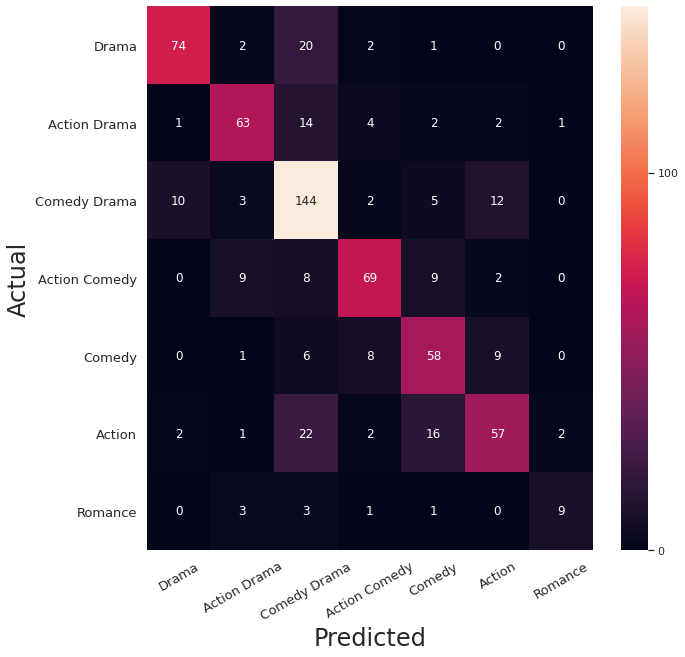

<Figure size 432x288 with 0 Axes>

In [167]:
sns.set(font=fontname)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#plt.tight_layout()
g=sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=data.new_genres.unique(), yticklabels=data.new_genres.unique())
g.set_xticklabels(rotation=30,labels=data.new_genres.unique(),size=13)
g.set_yticklabels(labels=data.new_genres.unique(),size=13)
plt.ylabel('Actual',size=24)
plt.xlabel('Predicted',size=24)
sns.set(font_scale=13)
plt.show()
plt.savefig('fig_conf_matrix.png',transparent=True,dpi=240, bbox_inches = "tight")